# <center><span style='background:yellow'> Participez à la conception d'une voiture autonome</span></center>
# <center><span style='background:yellow'>Test du modèle VGG16 UNET</span></center>


### Table of Contents <a class="anchor" id="sommaire"></a>

* [Introduction](#000)
* [Import et chargement des données](#0)
* [Définition des classes et fonctions communes](#00)
* [Cross entropy with logit](#1)
* [Weighted cross entropy with logit](#2)
* [Dice loss](#3)
* [Total loss](#4)

## Introduction <a class="anchor" id="000"></a>

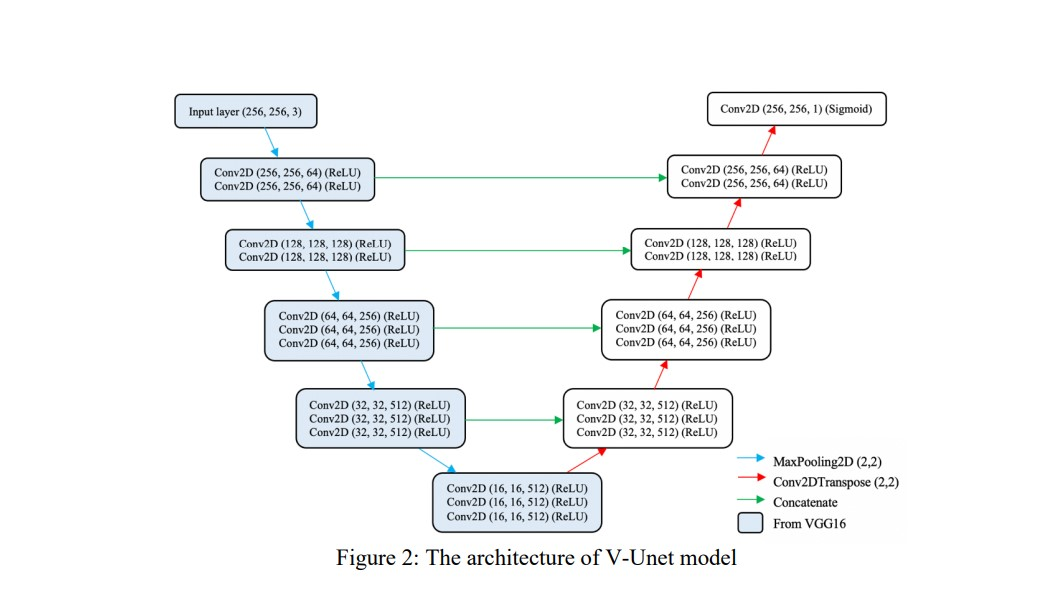

## Import et chargement des données <a class="anchor" id="0"></a>

In [15]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jan 26 08:33:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    50W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
import random
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import tensorflow as tf
import keras
import albumentations as A
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
print("Keras version : ", keras.__version__)
print("Tensorflow version : ", tf.__version__)

Keras version :  2.9.0
Tensorflow version :  2.9.2


In [19]:
df_paths = "/content/drive/MyDrive/data/"
train_path = pd.read_pickle(df_paths + 'train_path.pkl')
val_path = pd.read_pickle(df_paths + 'val_path.pkl')
test_path = pd.read_pickle(df_paths + 'test_path.pkl')

x_train = np.load(df_paths + 'x_train.npy')/255
x_val = np.load(df_paths + 'x_val.npy')/255
x_test = np.load(df_paths + 'x_test.npy')/255
y_train = np.load(df_paths + 'y_train.npy')
y_val = np.load(df_paths + 'y_val.npy')
y_test = np.load(df_paths + 'y_test.npy')

In [20]:
print("Dimension de xtrain :", x_train.shape)
print("Dimension de ytrain :", y_train.shape)
print("Dimension de xval :", x_val.shape)
print("Dimension de xval :", y_val.shape)
print("Dimension de xtest :", x_test.shape)
print("Dimension de ytest :", y_test.shape)

Dimension de xtrain : (2975, 128, 256, 3)
Dimension de ytrain : (2975, 128, 256, 8)
Dimension de xval : (350, 128, 256, 3)
Dimension de xval : (350, 128, 256, 8)
Dimension de xtest : (150, 128, 256, 3)
Dimension de ytest : (150, 128, 256, 8)


## Définition des classes et fonctions communes <a class="anchor" id="00"></a>

In [21]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.losses import binary_crossentropy

def weighted_cross_entropy(beta):
  def loss(y_true, y_pred):
    weight_a = beta * tf.cast(y_true, tf.float32)
    weight_b = 1 - tf.cast(y_true, tf.float32)
    
    o = (tf.math.log1p(tf.exp(-tf.abs(y_pred))) + tf.nn.relu(-y_pred)) * (weight_a + weight_b) + y_pred * weight_b 
    return tf.reduce_mean(o)

  return loss

def balanced_cross_entropy(beta):
  def loss(y_true, y_pred):
    weight_a = beta * tf.cast(y_true, tf.float32)
    weight_b = (1 - beta) * tf.cast(1 - y_true, tf.float32)
    
    o = (tf.math.log1p(tf.exp(-tf.abs(y_pred))) + tf.nn.relu(-y_pred)) * (weight_a + weight_b) + y_pred * weight_b
    return tf.reduce_mean(o)

  return loss


def dice_loss(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.math.sigmoid(y_pred)
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)

  return 1 - numerator / denominator

def total_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + (3*dice_loss(y_true, y_pred))
    return loss

### Définition des métriques

In [22]:
def dice_coeff(y_true, y_pred):
    score = 1 - dice_loss(y_true, y_pred)
    return score

def IoU(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.math.sigmoid(y_pred)
  intersection = tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred) - intersection

  return intersection / denominator

### Fonction de visualisation

In [23]:
import matplotlib.pyplot as plt
def plot_history(history, list_key) :
    
    # summarize history for accuracy
    plt.plot(history.history[list_key[0]])
    plt.plot(history.history[list_key[4]])
    plt.title(f'model {list_key[0]}')
    plt.ylabel(list_key[0])
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history[list_key[1]])
    plt.plot(history.history[list_key[5]])
    plt.title(f'model {list_key[1]}')
    plt.ylabel(list_key[1])
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


    # summarize history for loss
    plt.plot(history.history[list_key[2]])
    plt.plot(history.history[list_key[6]])
    plt.title(f'model {list_key[2]}')
    plt.ylabel(list_key[2])
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


    # summarize history for loss
    plt.plot(history.history[list_key[3]])
    plt.plot(history.history[list_key[7]])
    plt.title(f'model {list_key[3]}')
    plt.ylabel(list_key[3])
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

### Paramétres des modèles

In [24]:
epochs = 30

checkpoint_filepath = '/content/drive/MyDrive/checkpoint_unet/'

### Generator

In [25]:
transforms = A.Compose([
    
            A.HueSaturationValue(hue_shift_limit=20, 
                               sat_shift_limit=30, 
                               val_shift_limit=20, 
                               p=0.1),

            A.ISONoise(color_shift=(0.01, 0.05), 
                       intensity=(0.1, 0.5), 
                       always_apply=False, 
                       p=0.1),
            
            A.RandomBrightnessContrast(brightness_limit=0.2, 
                                       always_apply=False, 
                                       p=0.5),        

            A.Rotate(limit=10,
                   p = 0.1),
            
            A.RandomCrop(100,200, p=0.1),
            
            A.HorizontalFlip(p = 0.1),

            A.RandomSnow(p = 0.1),

            A.Resize(height=128, width=256, always_apply=True),
        ])

In [26]:
class MyGenerator(Sequence):

  def __init__(self, img_filesname, labels_filesname, batch_size=10, transformer= transforms, len_aug = 5):
    self.img_filesname = img_filesname
    self.labels_filesname = labels_filesname
    self.batch_size = batch_size
    self.transformer = transformer
    self.len_aug = len_aug

  def __len__(self):
    return int(np.ceil(len(self.img_filesname) / float(self.batch_size)))

  def __getitem__(self, idx):

    x_batch = self.img_filesname[idx*self.batch_size : (idx+1)*self.batch_size]
    y_batch = self.labels_filesname[idx*self.batch_size : (idx+1)*self.batch_size]

    x = [img_to_array(load_img(path, 
                               target_size = (128,256,3)),
                      dtype = "uint8")
            for path in x_batch
         ]
    
    y = [img_to_array(load_img(path, 
                               target_size = (128,256),  
                               color_mode = "grayscale"),
                      dtype = "uint8")
         
            for path in y_batch
        ]

    if self.transformer is not None:

      for i in range(self.len_aug):

        index = random.randint(0,2974)
        image = img_to_array(load_img(self.img_filesname[index], target_size = (128,256,3)),
                           dtype = 'uint8')
        mask = img_to_array(load_img(self.labels_filesname[index], target_size = (128,256), color_mode = "grayscale"),
                          dtype = "uint8")

        img_mask_transformed = self.transformer(image=image, mask=mask)
        new_image = img_mask_transformed['image'].astype('uint8')
        new_mask = img_mask_transformed['mask'].astype('uint8')        
        x.append(new_image)
        y.append(new_mask)

    x_ = np.array([im for im in x], dtype = "uint8")

    cats = {'void': [0, 1, 2, 3, 4, 5, 6],
            'flat': [7, 8, 9, 10],
            'construction': [11, 12, 13, 14, 15, 16],
            'object': [17, 18, 19, 20],
            'nature': [21, 22],
            'sky': [23],
            'human': [24, 25],
            'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]}
    y_8_cat = []
    for mask in y:
      mask = np.squeeze(mask)
      mask_transformed = np.zeros((mask.shape[0], mask.shape[1],8), dtype='uint8')
      
      for k in range(8):
        etiq_cat = cats[list(cats.keys())[k]]
        for j in etiq_cat:
          mask_transformed[:,:,k] = mask_transformed[:,:,k] | (mask==j) 

      y_8_cat.append(mask_transformed)

    y_8_cat_ = np.array([im for im in y_8_cat], dtype = "uint8")
    

    return x_/255. , y_8_cat_

In [27]:
batch_size = 10
len_aug = 10
training_generator = MyGenerator(train_path['image'].values,
                                 train_path['mask'].values,
                                 len_aug = len_aug,
                                 batch_size = batch_size)

val_generator = MyGenerator(val_path['image'].values,  
                            val_path['mask'].values, 
                            transformer = None,
                            batch_size = batch_size)

In [28]:
t0 = time()
s =  training_generator.__getitem__(1)
print(s[0].shape, s[1].shape)
print("time : ", round(time()-t0,2) , "s")

(20, 128, 256, 3) (20, 128, 256, 8)
time :  40.2 s


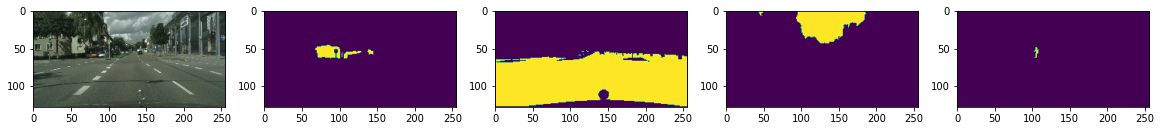

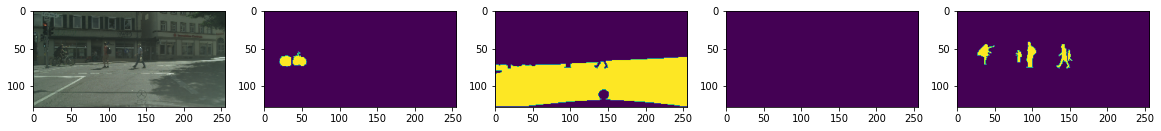

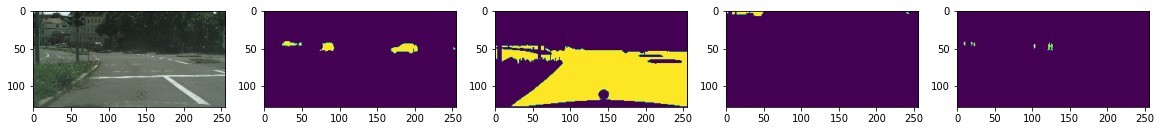

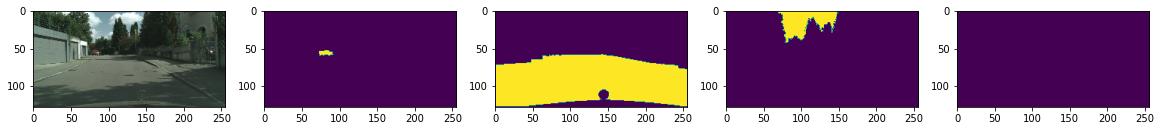

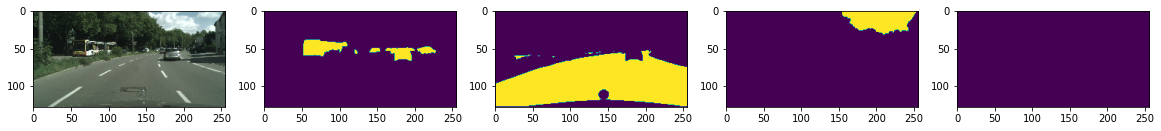

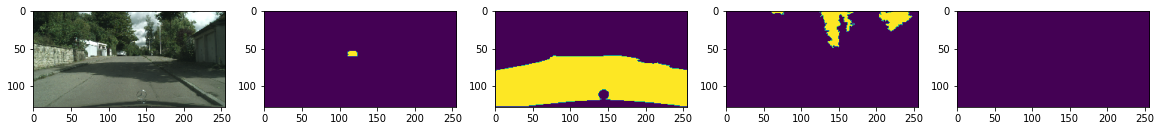

In [29]:
i = 0
for image, mask in zip(*s):
  fig = plt.figure(figsize=(20,5))
  ax0 = fig.add_subplot(151)
  ax0.imshow(image)
  ax1 = fig.add_subplot(152)
  ax1.imshow(mask[:,:,7])
  ax2 = fig.add_subplot(153)
  ax2.imshow(mask[:,:,1])
  ax3 = fig.add_subplot(154)
  ax3.imshow(mask[:,:,5])
  ax4 = fig.add_subplot(155)
  ax4.imshow(mask[:,:,6])
  plt.show()
  i += 1
  if i>5:
    break

In [30]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
import tensorflow as tf
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg_unet_model(input_shape = (128, 256, 3)):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG16 Model """
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = vgg16.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg16.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg16.get_layer("block3_conv3").output         ## (128 x 128)
    s4 = vgg16.get_layer("block4_conv3").output         ## (64 x 64)

    """ Bridge """
    b1 = vgg16.get_layer("block5_conv3").output         ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(8, 1, padding="same")(d4)

    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model

## Cross entropy with logit <a class="anchor" id="1"></a>

#### Entraînement du modèle sans augmentation des images

In [31]:
vgg_unet_model_ce = build_vgg_unet_model()

vgg_unet_model_ce.compile(optimizer = tf.keras.optimizers.Adam(),
                    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    metrics = ["accuracy", dice_coeff, IoU])

58889256/58889256 [==============================] - 0s 0us/step


In [32]:
vgg_unet_model_ce.summary()

Model: "VGG16_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                       

In [33]:
callbacks_es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                         patience = 3)

callbacks_chechpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath= checkpoint_filepath + '/VGG_UNET_CE',
    monitor = "val_loss",
    save_weights_only=False,
    mode='min',
    save_best_only=True)

callbacks = [callbacks_es, callbacks_chechpoint]

t0 = time()
vgg_unet_history_ce = vgg_unet_model_ce.fit(
    x = x_train,
    y = y_train,
    validation_data = (x_val, y_val),
    epochs = epochs,
    workers = 16,
    batch_size = batch_size,
    callbacks = [callbacks]
    )

t_vgg_unet_ce = time() - t0

Epoch 1/30
298/298 [==============================] - ETA: 0s - loss: 0.1783 - accuracy: 0.8107 - dice_coeff: 0.6292 - IoU: 0.4707

298/298 [==============================] - 34s 73ms/step - loss: 0.1783 - accuracy: 0.8107 - dice_coeff: 0.6292 - IoU: 0.4707 - val_loss: 0.4361 - val_accuracy: 0.4640 - val_dice_coeff: 0.4208 - val_IoU: 0.2668
Epoch 2/30
297/298 [============================>.] - ETA: 0s - loss: 0.0954 - accuracy: 0.8633 - dice_coeff: 0.7805 - IoU: 0.6406

298/298 [==============================] - 20s 66ms/step - loss: 0.0955 - accuracy: 0.8632 - dice_coeff: 0.7804 - IoU: 0.6405 - val_loss: 0.1127 - val_accuracy: 0.8401 - val_dice_coeff: 0.7871 - val_IoU: 0.6494
Epoch 3/30
297/298 [============================>.] - ETA: 0s - loss: 0.0847 - accuracy: 0.8762 - dice_coeff: 0.8079 - IoU: 0.6781

298/298 [==============================] - 19s 65ms/step - loss: 0.0847 - accuracy: 0.8762 - dice_coeff: 0.8079 - IoU: 0.6782 - val_loss: 0.1014 - val_accuracy: 0.8495 - val_dice_coeff: 0.7993 - val_IoU: 0.6664
Epoch 4/30
298/298 [==============================] - 13s 45ms/step - loss: 0.0769 - accuracy: 0.8875 - dice_coeff: 0.8267 - IoU: 0.7052 - val_loss: 0.1241 - val_accuracy: 0.8171 - val_dice_coeff: 0.7604 - val_IoU: 0.6143
Epoch 5/30
297/298 [============================>.] - ETA: 0s - loss: 0.0731 - accuracy: 0.8929 - dice_coeff: 0.8368 - IoU: 0.7199

298/298 [==============================] - 19s 64ms/step - loss: 0.0730 - accuracy: 0.8930 - dice_coeff: 0.8369 - IoU: 0.7201 - val_loss: 0.0864 - val_accuracy: 0.8697 - val_dice_coeff: 0.8185 - val_IoU: 0.6933
Epoch 6/30
298/298 [==============================] - 13s 45ms/step - loss: 0.0696 - accuracy: 0.8974 - dice_coeff: 0.8439 - IoU: 0.7305 - val_loss: 0.0901 - val_accuracy: 0.8721 - val_dice_coeff: 0.8370 - val_IoU: 0.7203
Epoch 7/30
298/298 [==============================] - 13s 45ms/step - loss: 0.0668 - accuracy: 0.9011 - dice_coeff: 0.8502 - IoU: 0.7398 - val_loss: 0.1073 - val_accuracy: 0.8382 - val_dice_coeff: 0.7864 - val_IoU: 0.6490
Epoch 8/30
298/298 [==============================] - 13s 45ms/step - loss: 0.0644 - accuracy: 0.9043 - dice_coeff: 0.8558 - IoU: 0.7483 - val_loss: 0.0886 - val_accuracy: 0.8725 - val_dice_coeff: 0.8323 - val_IoU: 0.7136


##### Learning Curve

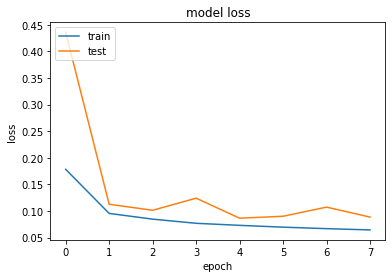

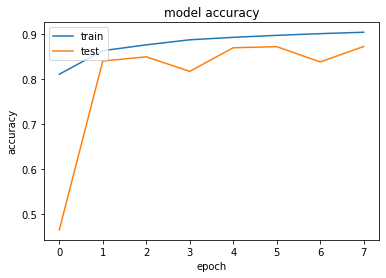

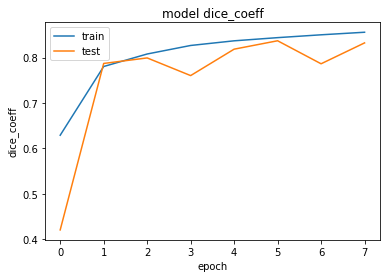

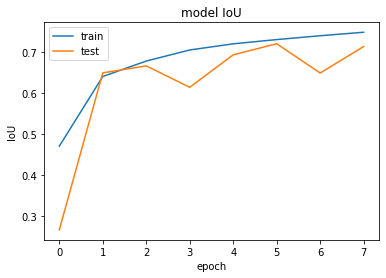

In [34]:
history = vgg_unet_history_ce
plot_history(history, list(history.history.keys()))

##### Evaluation

In [35]:
vgg_unet_evaluate_ce = vgg_unet_model_ce.evaluate(x_val,y_val)

11/11 [==============================] - 4s 191ms/step - loss: 0.0886 - accuracy: 0.8725 - dice_coeff: 0.8324 - IoU: 0.7130


In [36]:
print("UNET model loss:", round(vgg_unet_evaluate_ce[0],3))
print("UNET model accuracy:", round(vgg_unet_evaluate_ce[1],3))
print("UNET model dice coeff:", round(vgg_unet_evaluate_ce[2],3))
print("UNET model indice de Jacuard:", round(vgg_unet_evaluate_ce[3],3))
print("UNET model train time:", round(t_vgg_unet_ce/60,3), 'minutes')

UNET model loss: 0.089
UNET model accuracy: 0.872
UNET model dice coeff: 0.832
UNET model indice de Jacuard: 0.713
UNET model train time: 2.445 minutes


#### Entraînemet du modèle avec augmentation des images

In [37]:
aug_vgg_unet_model_ce = build_vgg_unet_model()

aug_vgg_unet_model_ce.compile(optimizer = tf.keras.optimizers.Adam(),
                    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    metrics = ["accuracy", dice_coeff, IoU])

In [38]:
aug_vgg_unet_model_ce.summary()

Model: "VGG16_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                       

In [39]:
batch_size = 10
len_aug = 20
training_generator = MyGenerator(train_path['image'].values,
                                 train_path['mask'].values,
                                 len_aug = len_aug,
                                 batch_size = batch_size)

val_generator = MyGenerator(val_path['image'].values,  
                            val_path['mask'].values, 
                            transformer = None,
                            batch_size = batch_size)

In [40]:
callbacks_es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                         patience = 3)

callbacks_chechpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath + '/AUG_VGG_UNET_CE',
    save_weights_only = False,
    mode='min',
    save_best_only = True)

callbacks = [callbacks_es, callbacks_chechpoint]

t0 = time()
aug_vgg_unet_history_ce = aug_vgg_unet_model_ce.fit(
    training_generator,
    validation_data = val_generator,
    epochs = epochs,
    workers = 16,
    callbacks = [callbacks]
    )


t_aug_vgg_unet_ce = time() - t0

Epoch 1/30
298/298 [==============================] - ETA: 0s - loss: 0.1806 - accuracy: 0.8061 - dice_coeff: 0.6234 - IoU: 0.4673

298/298 [==============================] - 286s 886ms/step - loss: 0.1806 - accuracy: 0.8061 - dice_coeff: 0.6234 - IoU: 0.4673 - val_loss: 0.1029 - val_accuracy: 0.8536 - val_dice_coeff: 0.7689 - val_IoU: 0.6249
Epoch 2/30
298/298 [==============================] - ETA: 0s - loss: 0.0890 - accuracy: 0.8715 - dice_coeff: 0.7938 - IoU: 0.6584

298/298 [==============================] - 146s 474ms/step - loss: 0.0890 - accuracy: 0.8715 - dice_coeff: 0.7938 - IoU: 0.6584 - val_loss: 0.0960 - val_accuracy: 0.8607 - val_dice_coeff: 0.7981 - val_IoU: 0.6648
Epoch 3/30
298/298 [==============================] - ETA: 0s - loss: 0.0761 - accuracy: 0.8876 - dice_coeff: 0.8263 - IoU: 0.7043

298/298 [==============================] - 145s 470ms/step - loss: 0.0761 - accuracy: 0.8876 - dice_coeff: 0.8263 - IoU: 0.7043 - val_loss: 0.0769 - val_accuracy: 0.8868 - val_dice_coeff: 0.8317 - val_IoU: 0.7124
Epoch 4/30
298/298 [==============================] - 140s 453ms/step - loss: 0.0701 - accuracy: 0.8948 - dice_coeff: 0.8406 - IoU: 0.7252 - val_loss: 0.0777 - val_accuracy: 0.8863 - val_dice_coeff: 0.8444 - val_IoU: 0.7312
Epoch 5/30
298/298 [==============================] - ETA: 0s - loss: 0.0661 - accuracy: 0.9004 - dice_coeff: 0.8504 - IoU: 0.7399

298/298 [==============================] - 145s 471ms/step - loss: 0.0661 - accuracy: 0.9004 - dice_coeff: 0.8504 - IoU: 0.7399 - val_loss: 0.0721 - val_accuracy: 0.8946 - val_dice_coeff: 0.8569 - val_IoU: 0.7501
Epoch 6/30
298/298 [==============================] - 140s 451ms/step - loss: 0.0623 - accuracy: 0.9057 - dice_coeff: 0.8591 - IoU: 0.7531 - val_loss: 0.0893 - val_accuracy: 0.8877 - val_dice_coeff: 0.8613 - val_IoU: 0.7569
Epoch 7/30
298/298 [==============================] - 141s 454ms/step - loss: 0.0582 - accuracy: 0.9118 - dice_coeff: 0.8683 - IoU: 0.7674 - val_loss: 0.0791 - val_accuracy: 0.8901 - val_dice_coeff: 0.8598 - val_IoU: 0.7547
Epoch 8/30
298/298 [==============================] - 139s 450ms/step - loss: 0.0556 - accuracy: 0.9157 - dice_coeff: 0.8745 - IoU: 0.7771 - val_loss: 0.0736 - val_accuracy: 0.8979 - val_dice_coeff: 0.8615 - val_IoU: 0.7573


##### Learning Curve

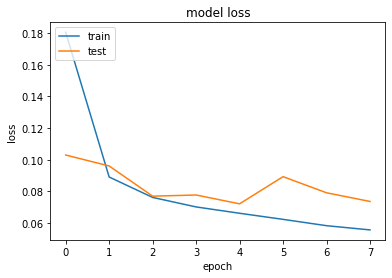

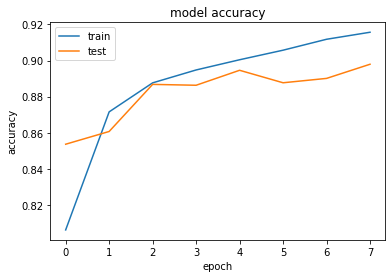

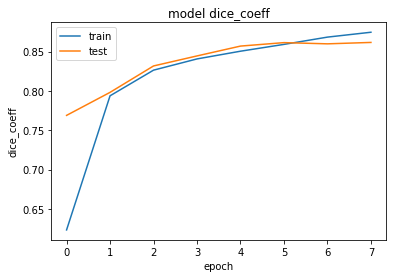

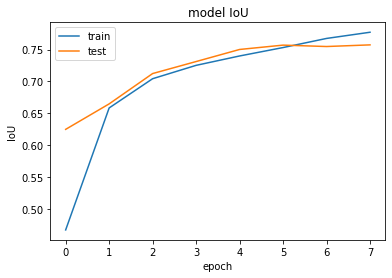

In [41]:
history = aug_vgg_unet_history_ce
plot_history(history, list(history.history.keys()))

##### Evaluation

In [42]:
aug_vgg_unet_evaluate_ce = aug_vgg_unet_model_ce.evaluate(x_val, y_val)

11/11 [==============================] - 0s 37ms/step - loss: 0.0736 - accuracy: 0.8979 - dice_coeff: 0.8616 - IoU: 0.7570


In [43]:
print("UNET model loss:", round(aug_vgg_unet_evaluate_ce[0],3))
print("UNET model accuracy:", round(aug_vgg_unet_evaluate_ce[1],3))
print("UNET model dice coeff:", round(aug_vgg_unet_evaluate_ce[2],3))
print("UNET model indice de Jacuard:", round(aug_vgg_unet_evaluate_ce[3],3))
print("UNET model train time:", round(t_aug_vgg_unet_ce/60,3), 'minutes')

UNET model loss: 0.074
UNET model accuracy: 0.898
UNET model dice coeff: 0.862
UNET model indice de Jacuard: 0.757
UNET model train time: 22.058 minutes


## Weighted cross entropy with logit <a class="anchor" id="2"></a>

#### Entraînement du modèle sans augmentation des images

In [44]:
vgg_unet_model_wce = build_vgg_unet_model()

vgg_unet_model_wce.compile(optimizer = tf.keras.optimizers.Adam(),
                    loss = weighted_cross_entropy(beta=2),
                    metrics = ["accuracy", dice_coeff, IoU])

In [45]:
vgg_unet_model_wce.summary()

Model: "VGG16_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 256, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                       

In [46]:
callbacks_es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                         patience = 3)

callbacks_chechpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath= checkpoint_filepath + '/VGG_UNET_WCE',
    monitor = "val_loss",
    save_weights_only=False,
    mode='min',
    save_best_only=True)

callbacks = [callbacks_es, callbacks_chechpoint]

t0 = time()
vgg_unet_history_wce = vgg_unet_model_wce.fit(
    x = x_train,
    y = y_train,
    validation_data = (x_val, y_val),
    epochs = epochs,
    workers = 16,
    batch_size = batch_size,
    callbacks = [callbacks]
    )

t_vgg_unet_wce = time() - t0

Epoch 1/30
298/298 [==============================] - ETA: 0s - loss: 0.2359 - accuracy: 0.8072 - dice_coeff: 0.6236 - IoU: 0.4635

298/298 [==============================] - 23s 69ms/step - loss: 0.2359 - accuracy: 0.8072 - dice_coeff: 0.6236 - IoU: 0.4635 - val_loss: 0.3456 - val_accuracy: 0.6617 - val_dice_coeff: 0.5908 - val_IoU: 0.4194
Epoch 2/30
298/298 [==============================] - ETA: 0s - loss: 0.1432 - accuracy: 0.8592 - dice_coeff: 0.7648 - IoU: 0.6198

298/298 [==============================] - 19s 65ms/step - loss: 0.1432 - accuracy: 0.8592 - dice_coeff: 0.7648 - IoU: 0.6198 - val_loss: 0.1570 - val_accuracy: 0.8433 - val_dice_coeff: 0.7781 - val_IoU: 0.6372
Epoch 3/30
298/298 [==============================] - ETA: 0s - loss: 0.1262 - accuracy: 0.8747 - dice_coeff: 0.7949 - IoU: 0.6601

298/298 [==============================] - 19s 65ms/step - loss: 0.1262 - accuracy: 0.8747 - dice_coeff: 0.7949 - IoU: 0.6601 - val_loss: 0.1477 - val_accuracy: 0.8500 - val_dice_coeff: 0.7906 - val_IoU: 0.6540
Epoch 4/30
298/298 [==============================] - ETA: 0s - loss: 0.1167 - accuracy: 0.8838 - dice_coeff: 0.8105 - IoU: 0.6818

298/298 [==============================] - 20s 66ms/step - loss: 0.1167 - accuracy: 0.8838 - dice_coeff: 0.8105 - IoU: 0.6818 - val_loss: 0.1342 - val_accuracy: 0.8667 - val_dice_coeff: 0.8069 - val_IoU: 0.6767
Epoch 5/30
298/298 [==============================] - 13s 44ms/step - loss: 0.1093 - accuracy: 0.8912 - dice_coeff: 0.8227 - IoU: 0.6991 - val_loss: 0.1435 - val_accuracy: 0.8516 - val_dice_coeff: 0.7935 - val_IoU: 0.6583
Epoch 6/30
298/298 [==============================] - 13s 44ms/step - loss: 0.1048 - accuracy: 0.8953 - dice_coeff: 0.8299 - IoU: 0.7097 - val_loss: 0.1382 - val_accuracy: 0.8630 - val_dice_coeff: 0.8140 - val_IoU: 0.6870
Epoch 7/30
297/298 [============================>.] - ETA: 0s - loss: 0.1010 - accuracy: 0.8991 - dice_coeff: 0.8362 - IoU: 0.7190

298/298 [==============================] - 19s 65ms/step - loss: 0.1010 - accuracy: 0.8991 - dice_coeff: 0.8362 - IoU: 0.7189 - val_loss: 0.1295 - val_accuracy: 0.8696 - val_dice_coeff: 0.8140 - val_IoU: 0.6867
Epoch 8/30
297/298 [============================>.] - ETA: 0s - loss: 0.0978 - accuracy: 0.9020 - dice_coeff: 0.8409 - IoU: 0.7260

298/298 [==============================] - 19s 64ms/step - loss: 0.0979 - accuracy: 0.9019 - dice_coeff: 0.8409 - IoU: 0.7259 - val_loss: 0.1191 - val_accuracy: 0.8811 - val_dice_coeff: 0.8265 - val_IoU: 0.7048
Epoch 9/30
298/298 [==============================] - 13s 45ms/step - loss: 0.0938 - accuracy: 0.9057 - dice_coeff: 0.8470 - IoU: 0.7351 - val_loss: 0.1443 - val_accuracy: 0.8586 - val_dice_coeff: 0.8105 - val_IoU: 0.6820
Epoch 10/30
298/298 [==============================] - 13s 44ms/step - loss: 0.0904 - accuracy: 0.9085 - dice_coeff: 0.8517 - IoU: 0.7421 - val_loss: 0.1323 - val_accuracy: 0.8746 - val_dice_coeff: 0.8260 - val_IoU: 0.7040
Epoch 11/30
298/298 [==============================] - 13s 44ms/step - loss: 0.0889 - accuracy: 0.9100 - dice_coeff: 0.8548 - IoU: 0.7469 - val_loss: 0.1225 - val_accuracy: 0.8869 - val_dice_coeff: 0.8472 - val_IoU: 0.7354


##### Learning Curve

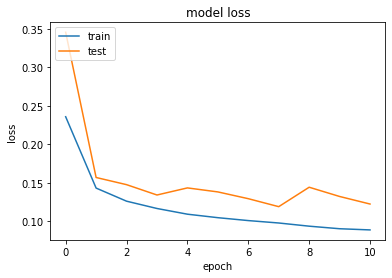

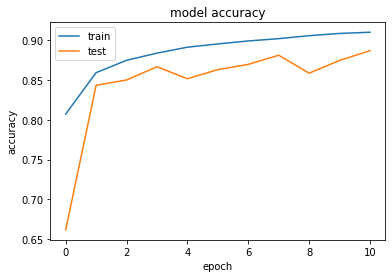

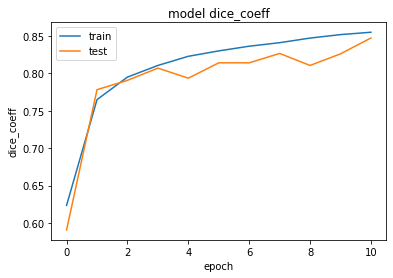

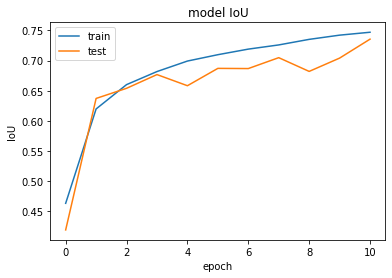

In [47]:
history = vgg_unet_history_wce
plot_history(history, list(history.history.keys()))

##### Evaluation

In [48]:
vgg_unet_evaluate_wce = vgg_unet_model_wce.evaluate(x_val,y_val)

11/11 [==============================] - 1s 37ms/step - loss: 0.1225 - accuracy: 0.8869 - dice_coeff: 0.8472 - IoU: 0.7351


In [49]:
print("UNET model loss:", round(vgg_unet_evaluate_wce[0],3))
print("UNET model accuracy:", round(vgg_unet_evaluate_wce[1],3))
print("UNET model dice coeff:", round(vgg_unet_evaluate_wce[2],3))
print("UNET model indice de Jacuard:", round(vgg_unet_evaluate_wce[3],3))
print("UNET model train time:", round(t_vgg_unet_wce/60,3), 'minutes')

UNET model loss: 0.123
UNET model accuracy: 0.887
UNET model dice coeff: 0.847
UNET model indice de Jacuard: 0.735
UNET model train time: 3.107 minutes


#### Entraînemet du modèle avec augmentation des images

In [90]:
aug_vgg_unet_model_wce = build_vgg_unet_model()

aug_vgg_unet_model_wce.compile(optimizer = tf.keras.optimizers.Adam(),
                    loss = weighted_cross_entropy(beta=2),
                    metrics = ["accuracy", dice_coeff, IoU])

In [91]:
aug_vgg_unet_model_wce.summary()

Model: "VGG16_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 128, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 256, 64  1792        ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                       

In [92]:
batch_size = 10
len_aug = 50
training_generator = MyGenerator(train_path['image'].values,
                                 train_path['mask'].values,
                                 len_aug = len_aug,
                                 batch_size = batch_size)

val_generator = MyGenerator(val_path['image'].values,  
                            val_path['mask'].values, 
                            transformer = None,
                            batch_size = batch_size)

In [93]:
callbacks_es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                         patience = 3)

callbacks_chechpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath + '/AUG_VGG_UNET_WCE',
    save_weights_only = False,
    mode='min',
    save_best_only = True)

callbacks = [callbacks_es, callbacks_chechpoint]

t0 = time()
aug_vgg_unet_history_wce = aug_vgg_unet_model_wce.fit(
    training_generator,
    validation_data = val_generator,
    epochs = epochs,
    workers = 16,
    callbacks = [callbacks]
    )

t_aug_vgg_unet_wce = time() - t0

Epoch 1/30
298/298 [==============================] - ETA: 0s - loss: 0.1968 - accuracy: 0.8318 - dice_coeff: 0.6745 - IoU: 0.5209

298/298 [==============================] - 287s 903ms/step - loss: 0.1968 - accuracy: 0.8318 - dice_coeff: 0.6745 - IoU: 0.5209 - val_loss: 0.1390 - val_accuracy: 0.8627 - val_dice_coeff: 0.7822 - val_IoU: 0.6427
Epoch 2/30
298/298 [==============================] - ETA: 0s - loss: 0.1137 - accuracy: 0.8861 - dice_coeff: 0.8100 - IoU: 0.6809

298/298 [==============================] - 279s 902ms/step - loss: 0.1137 - accuracy: 0.8861 - dice_coeff: 0.8100 - IoU: 0.6809 - val_loss: 0.1216 - val_accuracy: 0.8850 - val_dice_coeff: 0.8310 - val_IoU: 0.7113
Epoch 3/30
298/298 [==============================] - 269s 869ms/step - loss: 0.0984 - accuracy: 0.8991 - dice_coeff: 0.8367 - IoU: 0.7194 - val_loss: 0.1239 - val_accuracy: 0.8915 - val_dice_coeff: 0.8466 - val_IoU: 0.7345
Epoch 4/30
298/298 [==============================] - ETA: 0s - loss: 0.0870 - accuracy: 0.9103 - dice_coeff: 0.8558 - IoU: 0.7480

298/298 [==============================] - 284s 902ms/step - loss: 0.0870 - accuracy: 0.9103 - dice_coeff: 0.8558 - IoU: 0.7480 - val_loss: 0.1054 - val_accuracy: 0.8961 - val_dice_coeff: 0.8546 - val_IoU: 0.7466
Epoch 5/30
298/298 [==============================] - 268s 864ms/step - loss: 0.0797 - accuracy: 0.9175 - dice_coeff: 0.8677 - IoU: 0.7664 - val_loss: 0.1283 - val_accuracy: 0.8848 - val_dice_coeff: 0.8436 - val_IoU: 0.7302
Epoch 6/30
298/298 [==============================] - 273s 866ms/step - loss: 0.0754 - accuracy: 0.9214 - dice_coeff: 0.8748 - IoU: 0.7776 - val_loss: 0.1148 - val_accuracy: 0.9012 - val_dice_coeff: 0.8646 - val_IoU: 0.7621
Epoch 7/30
298/298 [==============================] - 273s 865ms/step - loss: 0.0705 - accuracy: 0.9263 - dice_coeff: 0.8827 - IoU: 0.7901 - val_loss: 0.1082 - val_accuracy: 0.9042 - val_dice_coeff: 0.8678 - val_IoU: 0.7669


##### Learning Curve

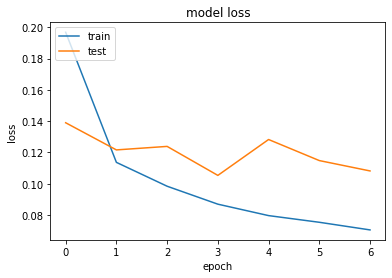

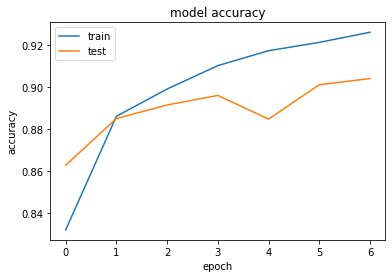

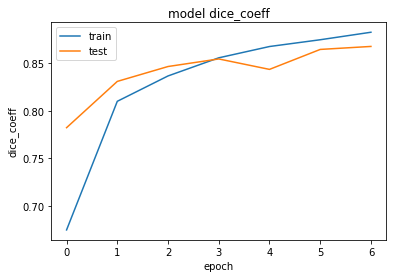

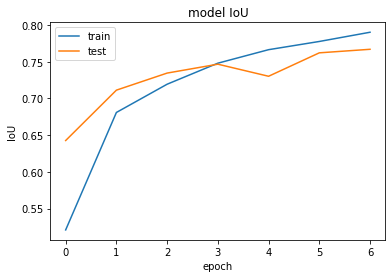

In [94]:
history = aug_vgg_unet_history_wce
plot_history(history, list(history.history.keys()))

##### Evaluation

In [95]:
aug_vgg_unet_evaluate_wce = aug_vgg_unet_model_wce.evaluate(x_val, y_val)

11/11 [==============================] - 0s 41ms/step - loss: 0.1082 - accuracy: 0.9042 - dice_coeff: 0.8678 - IoU: 0.7666


In [96]:
print("UNET model loss:", round(aug_vgg_unet_evaluate_wce[0],3))
print("UNET model accuracy:", round(aug_vgg_unet_evaluate_wce[1],3))
print("UNET model dice coeff:", round(aug_vgg_unet_evaluate_wce[2],3))
print("UNET model indice de Jacuard:", round(aug_vgg_unet_evaluate_wce[3],3))
print("UNET model train time:", round(t_aug_vgg_unet_wce/60,3), 'minutes')

UNET model loss: 0.108
UNET model accuracy: 0.904
UNET model dice coeff: 0.868
UNET model indice de Jacuard: 0.767
UNET model train time: 32.314 minutes


## Dice loss <a class="anchor" id="3"></a>

#### Entraînement du modèle sans augmentation des images

In [57]:
vgg_unet_model_dl = build_vgg_unet_model()

vgg_unet_model_dl.compile(optimizer = tf.keras.optimizers.Adam(),
                    loss = dice_loss,
                    metrics = ["accuracy", dice_coeff, IoU])

In [58]:
vgg_unet_model_dl.summary()

Model: "VGG16_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 256, 64  1792        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                       

In [59]:
callbacks_es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                         patience = 3)

callbacks_chechpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath= checkpoint_filepath + '/VGG_UNET_DL',
    monitor = "val_loss",
    save_weights_only=False,
    mode='min',
    save_best_only=True)

callbacks = [callbacks_es, callbacks_chechpoint]

t0 = time()
vgg_unet_history_dl = vgg_unet_model_dl.fit(
    x = x_train,
    y = y_train,
    validation_data = (x_val, y_val),
    epochs = epochs,
    workers = 16,
    batch_size = batch_size,
    callbacks = [callbacks]
    )

t_vgg_unet_dl = time() - t0

Epoch 1/30
297/298 [============================>.] - ETA: 0s - loss: 0.2642 - accuracy: 0.8127 - dice_coeff: 0.7358 - IoU: 0.6008

298/298 [==============================] - 22s 68ms/step - loss: 0.2639 - accuracy: 0.8128 - dice_coeff: 0.7363 - IoU: 0.6013 - val_loss: 0.2431 - val_accuracy: 0.8051 - val_dice_coeff: 0.7569 - val_IoU: 0.6093
Epoch 2/30
297/298 [============================>.] - ETA: 0s - loss: 0.1433 - accuracy: 0.8589 - dice_coeff: 0.8567 - IoU: 0.7500

298/298 [==============================] - 19s 65ms/step - loss: 0.1433 - accuracy: 0.8590 - dice_coeff: 0.8568 - IoU: 0.7502 - val_loss: 0.2202 - val_accuracy: 0.7881 - val_dice_coeff: 0.7798 - val_IoU: 0.6401
Epoch 3/30
297/298 [============================>.] - ETA: 0s - loss: 0.1282 - accuracy: 0.8698 - dice_coeff: 0.8718 - IoU: 0.7734

298/298 [==============================] - 19s 65ms/step - loss: 0.1282 - accuracy: 0.8698 - dice_coeff: 0.8718 - IoU: 0.7735 - val_loss: 0.1429 - val_accuracy: 0.8532 - val_dice_coeff: 0.8571 - val_IoU: 0.7507
Epoch 4/30
298/298 [==============================] - 13s 44ms/step - loss: 0.1179 - accuracy: 0.8784 - dice_coeff: 0.8820 - IoU: 0.7896 - val_loss: 0.1429 - val_accuracy: 0.8545 - val_dice_coeff: 0.8571 - val_IoU: 0.7505
Epoch 5/30
297/298 [============================>.] - ETA: 0s - loss: 0.1127 - accuracy: 0.8826 - dice_coeff: 0.8873 - IoU: 0.7981

298/298 [==============================] - 19s 63ms/step - loss: 0.1128 - accuracy: 0.8825 - dice_coeff: 0.8871 - IoU: 0.7978 - val_loss: 0.1327 - val_accuracy: 0.8622 - val_dice_coeff: 0.8673 - val_IoU: 0.7663
Epoch 6/30
298/298 [==============================] - ETA: 0s - loss: 0.1079 - accuracy: 0.8870 - dice_coeff: 0.8921 - IoU: 0.8059

298/298 [==============================] - 19s 65ms/step - loss: 0.1079 - accuracy: 0.8870 - dice_coeff: 0.8921 - IoU: 0.8059 - val_loss: 0.1263 - val_accuracy: 0.8672 - val_dice_coeff: 0.8737 - val_IoU: 0.7765
Epoch 7/30
297/298 [============================>.] - ETA: 0s - loss: 0.1031 - accuracy: 0.8913 - dice_coeff: 0.8969 - IoU: 0.8137

298/298 [==============================] - 20s 66ms/step - loss: 0.1031 - accuracy: 0.8913 - dice_coeff: 0.8969 - IoU: 0.8137 - val_loss: 0.1217 - val_accuracy: 0.8724 - val_dice_coeff: 0.8783 - val_IoU: 0.7836
Epoch 8/30
298/298 [==============================] - ETA: 0s - loss: 0.0997 - accuracy: 0.8942 - dice_coeff: 0.9003 - IoU: 0.8193

298/298 [==============================] - 19s 65ms/step - loss: 0.0997 - accuracy: 0.8942 - dice_coeff: 0.9003 - IoU: 0.8193 - val_loss: 0.1154 - val_accuracy: 0.8765 - val_dice_coeff: 0.8846 - val_IoU: 0.7936
Epoch 9/30
298/298 [==============================] - 13s 44ms/step - loss: 0.0970 - accuracy: 0.8966 - dice_coeff: 0.9031 - IoU: 0.8239 - val_loss: 0.1173 - val_accuracy: 0.8763 - val_dice_coeff: 0.8827 - val_IoU: 0.7907
Epoch 10/30
297/298 [============================>.] - ETA: 0s - loss: 0.0959 - accuracy: 0.8975 - dice_coeff: 0.9041 - IoU: 0.8257

298/298 [==============================] - 19s 63ms/step - loss: 0.0959 - accuracy: 0.8975 - dice_coeff: 0.9041 - IoU: 0.8257 - val_loss: 0.1096 - val_accuracy: 0.8828 - val_dice_coeff: 0.8904 - val_IoU: 0.8030
Epoch 11/30
298/298 [==============================] - 13s 44ms/step - loss: 0.0921 - accuracy: 0.9009 - dice_coeff: 0.9079 - IoU: 0.8319 - val_loss: 0.1181 - val_accuracy: 0.8732 - val_dice_coeff: 0.8819 - val_IoU: 0.7894
Epoch 12/30
298/298 [==============================] - 13s 44ms/step - loss: 0.0922 - accuracy: 0.9007 - dice_coeff: 0.9079 - IoU: 0.8319 - val_loss: 0.1119 - val_accuracy: 0.8795 - val_dice_coeff: 0.8881 - val_IoU: 0.7994
Epoch 13/30
297/298 [============================>.] - ETA: 0s - loss: 0.0890 - accuracy: 0.9036 - dice_coeff: 0.9110 - IoU: 0.8371

298/298 [==============================] - 19s 65ms/step - loss: 0.0891 - accuracy: 0.9035 - dice_coeff: 0.9108 - IoU: 0.8367 - val_loss: 0.1042 - val_accuracy: 0.8872 - val_dice_coeff: 0.8958 - val_IoU: 0.8119
Epoch 14/30
297/298 [============================>.] - ETA: 0s - loss: 0.0872 - accuracy: 0.9051 - dice_coeff: 0.9128 - IoU: 0.8401

298/298 [==============================] - 19s 65ms/step - loss: 0.0872 - accuracy: 0.9051 - dice_coeff: 0.9127 - IoU: 0.8400 - val_loss: 0.1039 - val_accuracy: 0.8873 - val_dice_coeff: 0.8961 - val_IoU: 0.8123
Epoch 15/30
298/298 [==============================] - 13s 44ms/step - loss: 0.0857 - accuracy: 0.9066 - dice_coeff: 0.9143 - IoU: 0.8428 - val_loss: 0.1049 - val_accuracy: 0.8863 - val_dice_coeff: 0.8951 - val_IoU: 0.8108
Epoch 16/30
298/298 [==============================] - 13s 44ms/step - loss: 0.0858 - accuracy: 0.9064 - dice_coeff: 0.9142 - IoU: 0.8426 - val_loss: 0.1106 - val_accuracy: 0.8810 - val_dice_coeff: 0.8894 - val_IoU: 0.8015
Epoch 17/30
297/298 [============================>.] - ETA: 0s - loss: 0.0846 - accuracy: 0.9076 - dice_coeff: 0.9154 - IoU: 0.8445

298/298 [==============================] - 19s 65ms/step - loss: 0.0846 - accuracy: 0.9076 - dice_coeff: 0.9154 - IoU: 0.8446 - val_loss: 0.1036 - val_accuracy: 0.8877 - val_dice_coeff: 0.8964 - val_IoU: 0.8128
Epoch 18/30
297/298 [============================>.] - ETA: 0s - loss: 0.0826 - accuracy: 0.9092 - dice_coeff: 0.9174 - IoU: 0.8480

298/298 [==============================] - 19s 65ms/step - loss: 0.0825 - accuracy: 0.9093 - dice_coeff: 0.9175 - IoU: 0.8481 - val_loss: 0.0996 - val_accuracy: 0.8915 - val_dice_coeff: 0.9004 - val_IoU: 0.8195
Epoch 19/30
298/298 [==============================] - 13s 44ms/step - loss: 0.0810 - accuracy: 0.9108 - dice_coeff: 0.9190 - IoU: 0.8508 - val_loss: 0.1026 - val_accuracy: 0.8886 - val_dice_coeff: 0.8974 - val_IoU: 0.8145
Epoch 20/30
298/298 [==============================] - 13s 44ms/step - loss: 0.0803 - accuracy: 0.9115 - dice_coeff: 0.9198 - IoU: 0.8520 - val_loss: 0.1005 - val_accuracy: 0.8907 - val_dice_coeff: 0.8995 - val_IoU: 0.8179
Epoch 21/30
298/298 [==============================] - 13s 44ms/step - loss: 0.0794 - accuracy: 0.9123 - dice_coeff: 0.9206 - IoU: 0.8535 - val_loss: 0.1015 - val_accuracy: 0.8890 - val_dice_coeff: 0.8985 - val_IoU: 0.8162


##### Learning Curve

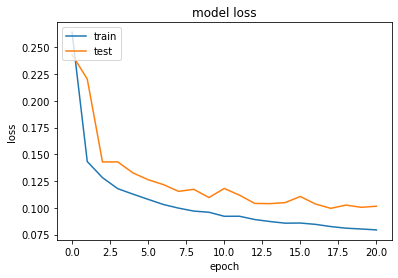

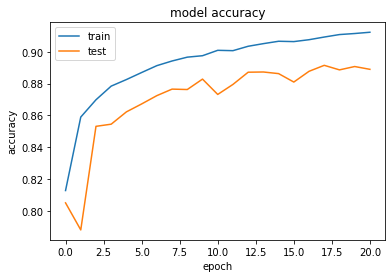

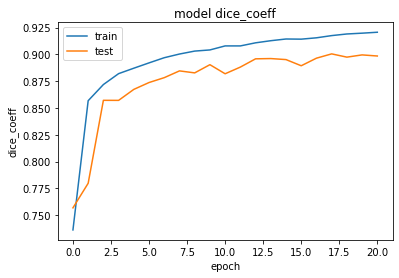

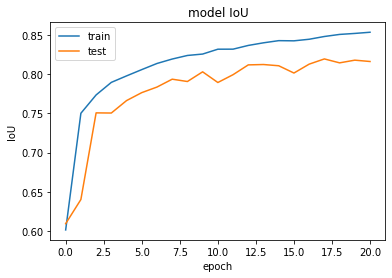

In [60]:
history = vgg_unet_history_dl
plot_history(history, list(history.history.keys()))

##### Evaluation

In [61]:
vgg_unet_evaluate_dl = vgg_unet_model_dl.evaluate(x_val,y_val)

11/11 [==============================] - 1s 36ms/step - loss: 0.1015 - accuracy: 0.8890 - dice_coeff: 0.8985 - IoU: 0.8159


In [62]:
print("UNET model loss:", round(vgg_unet_evaluate_dl[0],3))
print("UNET model accuracy:", round(vgg_unet_evaluate_dl[1],3))
print("UNET model dice coeff:", round(vgg_unet_evaluate_dl[2],3))
print("UNET model indice de Jacuard:", round(vgg_unet_evaluate_dl[3],3))
print("UNET model train time:", round(t_vgg_unet_dl/60,3), 'minutes')

UNET model loss: 0.102
UNET model accuracy: 0.889
UNET model dice coeff: 0.899
UNET model indice de Jacuard: 0.816
UNET model train time: 5.877 minutes


#### Entraînemet du modèle avec augmentation des images

In [63]:
aug_vgg_unet_model_dl = build_vgg_unet_model()

aug_vgg_unet_model_dl.compile(optimizer = tf.keras.optimizers.Adam(),
                    loss = dice_loss,
                    metrics = ["accuracy", dice_coeff, IoU])

In [64]:
aug_vgg_unet_model_dl.summary()

Model: "VGG16_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 256, 64  1792        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                       

In [65]:
batch_size = 10
len_aug = 20
training_generator = MyGenerator(train_path['image'].values,
                                 train_path['mask'].values,
                                 len_aug = len_aug,
                                 batch_size = batch_size)

val_generator = MyGenerator(val_path['image'].values,  
                            val_path['mask'].values, 
                            transformer = None,
                            batch_size = batch_size)

In [66]:
callbacks_es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                         patience = 3)

callbacks_chechpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath + '/AUG_VGG_UNET_DL',
    save_weights_only = False,
    mode='min',
    save_best_only = True)

callbacks = [callbacks_es, callbacks_chechpoint]

t0 = time()
aug_vgg_unet_history_dl = aug_vgg_unet_model_dl.fit(
    training_generator,
    validation_data = val_generator,
    epochs = epochs,
    workers = 16,
    callbacks = [callbacks]
    )

t_aug_vgg_unet_dl = time() - t0

Epoch 1/30
298/298 [==============================] - ETA: 0s - loss: 0.2709 - accuracy: 0.8049 - dice_coeff: 0.7291 - IoU: 0.5949

298/298 [==============================] - 149s 475ms/step - loss: 0.2709 - accuracy: 0.8049 - dice_coeff: 0.7291 - IoU: 0.5949 - val_loss: 0.2059 - val_accuracy: 0.8052 - val_dice_coeff: 0.7941 - val_IoU: 0.6590
Epoch 2/30
298/298 [==============================] - ETA: 0s - loss: 0.1320 - accuracy: 0.8672 - dice_coeff: 0.8680 - IoU: 0.7671

298/298 [==============================] - 146s 473ms/step - loss: 0.1320 - accuracy: 0.8672 - dice_coeff: 0.8680 - IoU: 0.7671 - val_loss: 0.1414 - val_accuracy: 0.8546 - val_dice_coeff: 0.8586 - val_IoU: 0.7530
Epoch 3/30
298/298 [==============================] - ETA: 0s - loss: 0.1173 - accuracy: 0.8784 - dice_coeff: 0.8827 - IoU: 0.7904

298/298 [==============================] - 146s 474ms/step - loss: 0.1173 - accuracy: 0.8784 - dice_coeff: 0.8827 - IoU: 0.7904 - val_loss: 0.1234 - val_accuracy: 0.8700 - val_dice_coeff: 0.8766 - val_IoU: 0.7809
Epoch 4/30
298/298 [==============================] - ETA: 0s - loss: 0.1086 - accuracy: 0.8856 - dice_coeff: 0.8914 - IoU: 0.8043

298/298 [==============================] - 148s 478ms/step - loss: 0.1086 - accuracy: 0.8856 - dice_coeff: 0.8914 - IoU: 0.8043 - val_loss: 0.1116 - val_accuracy: 0.8808 - val_dice_coeff: 0.8884 - val_IoU: 0.7997
Epoch 5/30
298/298 [==============================] - ETA: 0s - loss: 0.1020 - accuracy: 0.8916 - dice_coeff: 0.8980 - IoU: 0.8152

298/298 [==============================] - 146s 473ms/step - loss: 0.1020 - accuracy: 0.8916 - dice_coeff: 0.8980 - IoU: 0.8152 - val_loss: 0.1090 - val_accuracy: 0.8823 - val_dice_coeff: 0.8910 - val_IoU: 0.8041
Epoch 6/30
298/298 [==============================] - ETA: 0s - loss: 0.0979 - accuracy: 0.8953 - dice_coeff: 0.9022 - IoU: 0.8220

298/298 [==============================] - 149s 482ms/step - loss: 0.0979 - accuracy: 0.8953 - dice_coeff: 0.9022 - IoU: 0.8220 - val_loss: 0.1060 - val_accuracy: 0.8853 - val_dice_coeff: 0.8940 - val_IoU: 0.8089
Epoch 7/30
298/298 [==============================] - ETA: 0s - loss: 0.0962 - accuracy: 0.8963 - dice_coeff: 0.9038 - IoU: 0.8247

298/298 [==============================] - 146s 474ms/step - loss: 0.0962 - accuracy: 0.8963 - dice_coeff: 0.9038 - IoU: 0.8247 - val_loss: 0.1051 - val_accuracy: 0.8859 - val_dice_coeff: 0.8949 - val_IoU: 0.8103
Epoch 8/30
298/298 [==============================] - ETA: 0s - loss: 0.0931 - accuracy: 0.8992 - dice_coeff: 0.9069 - IoU: 0.8300

298/298 [==============================] - 147s 477ms/step - loss: 0.0931 - accuracy: 0.8992 - dice_coeff: 0.9069 - IoU: 0.8300 - val_loss: 0.1048 - val_accuracy: 0.8857 - val_dice_coeff: 0.8952 - val_IoU: 0.8108
Epoch 9/30
298/298 [==============================] - ETA: 0s - loss: 0.0914 - accuracy: 0.9009 - dice_coeff: 0.9086 - IoU: 0.8328

298/298 [==============================] - 147s 475ms/step - loss: 0.0914 - accuracy: 0.9009 - dice_coeff: 0.9086 - IoU: 0.8328 - val_loss: 0.1038 - val_accuracy: 0.8864 - val_dice_coeff: 0.8962 - val_IoU: 0.8125
Epoch 10/30
298/298 [==============================] - 140s 453ms/step - loss: 0.0917 - accuracy: 0.9003 - dice_coeff: 0.9083 - IoU: 0.8322 - val_loss: 0.1045 - val_accuracy: 0.8858 - val_dice_coeff: 0.8955 - val_IoU: 0.8114
Epoch 11/30
298/298 [==============================] - ETA: 0s - loss: 0.0890 - accuracy: 0.9029 - dice_coeff: 0.9110 - IoU: 0.8367

298/298 [==============================] - 150s 485ms/step - loss: 0.0890 - accuracy: 0.9029 - dice_coeff: 0.9110 - IoU: 0.8367 - val_loss: 0.1000 - val_accuracy: 0.8904 - val_dice_coeff: 0.9000 - val_IoU: 0.8188
Epoch 12/30
298/298 [==============================] - ETA: 0s - loss: 0.0858 - accuracy: 0.9059 - dice_coeff: 0.9142 - IoU: 0.8422

298/298 [==============================] - 148s 478ms/step - loss: 0.0858 - accuracy: 0.9059 - dice_coeff: 0.9142 - IoU: 0.8422 - val_loss: 0.0996 - val_accuracy: 0.8897 - val_dice_coeff: 0.9004 - val_IoU: 0.8194
Epoch 13/30
298/298 [==============================] - ETA: 0s - loss: 0.0823 - accuracy: 0.9093 - dice_coeff: 0.9177 - IoU: 0.8481

298/298 [==============================] - 146s 474ms/step - loss: 0.0823 - accuracy: 0.9093 - dice_coeff: 0.9177 - IoU: 0.8481 - val_loss: 0.0987 - val_accuracy: 0.8912 - val_dice_coeff: 0.9013 - val_IoU: 0.8209
Epoch 14/30
298/298 [==============================] - 141s 456ms/step - loss: 0.0831 - accuracy: 0.9083 - dice_coeff: 0.9169 - IoU: 0.8468 - val_loss: 0.1011 - val_accuracy: 0.8880 - val_dice_coeff: 0.8989 - val_IoU: 0.8169
Epoch 15/30
298/298 [==============================] - ETA: 0s - loss: 0.0803 - accuracy: 0.9112 - dice_coeff: 0.9197 - IoU: 0.8515

298/298 [==============================] - 145s 471ms/step - loss: 0.0803 - accuracy: 0.9112 - dice_coeff: 0.9197 - IoU: 0.8515 - val_loss: 0.0986 - val_accuracy: 0.8904 - val_dice_coeff: 0.9014 - val_IoU: 0.8210
Epoch 16/30
298/298 [==============================] - ETA: 0s - loss: 0.0805 - accuracy: 0.9107 - dice_coeff: 0.9195 - IoU: 0.8512

298/298 [==============================] - 147s 477ms/step - loss: 0.0805 - accuracy: 0.9107 - dice_coeff: 0.9195 - IoU: 0.8512 - val_loss: 0.0957 - val_accuracy: 0.8943 - val_dice_coeff: 0.9043 - val_IoU: 0.8259
Epoch 17/30
298/298 [==============================] - 140s 452ms/step - loss: 0.0803 - accuracy: 0.9110 - dice_coeff: 0.9197 - IoU: 0.8516 - val_loss: 0.0970 - val_accuracy: 0.8926 - val_dice_coeff: 0.9030 - val_IoU: 0.8238
Epoch 18/30
298/298 [==============================] - 141s 452ms/step - loss: 0.0796 - accuracy: 0.9114 - dice_coeff: 0.9204 - IoU: 0.8527 - val_loss: 0.0977 - val_accuracy: 0.8938 - val_dice_coeff: 0.9023 - val_IoU: 0.8226
Epoch 19/30
298/298 [==============================] - 140s 454ms/step - loss: 0.0785 - accuracy: 0.9126 - dice_coeff: 0.9215 - IoU: 0.8547 - val_loss: 0.0999 - val_accuracy: 0.8898 - val_dice_coeff: 0.9001 - val_IoU: 0.8189


##### Learning Curve

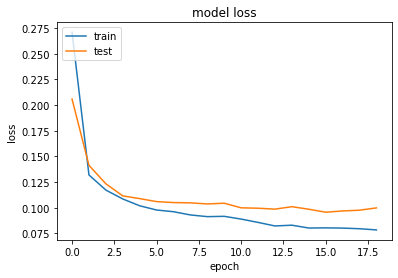

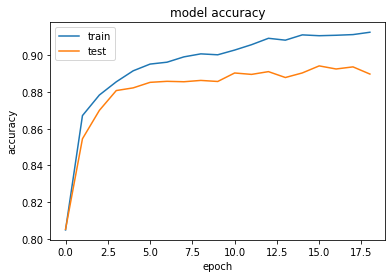

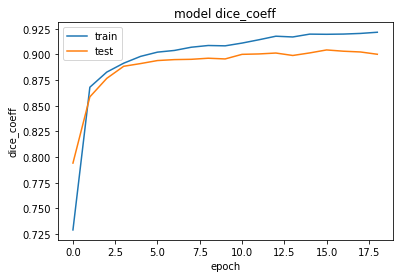

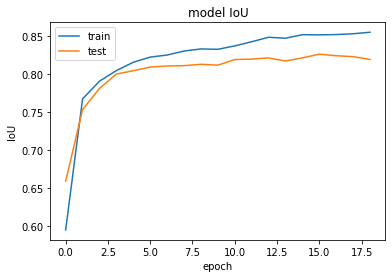

In [67]:
history = aug_vgg_unet_history_dl
plot_history(history, list(history.history.keys()))

##### Evaluation

In [68]:
aug_vgg_unet_evaluate_dl = aug_vgg_unet_model_dl.evaluate(x_val, y_val)

11/11 [==============================] - 0s 36ms/step - loss: 0.0999 - accuracy: 0.8898 - dice_coeff: 0.9002 - IoU: 0.8186


In [69]:
print("UNET model loss:", round(aug_vgg_unet_evaluate_dl[0],3))
print("UNET model accuracy:", round(aug_vgg_unet_evaluate_dl[1],3))
print("UNET model dice coeff:", round(aug_vgg_unet_evaluate_dl[2],3))
print("UNET model indice de Jacuard:", round(aug_vgg_unet_evaluate_dl[3],3))
print("UNET model train time:", round(t_aug_vgg_unet_dl/60,3), 'minutes')

UNET model loss: 0.1
UNET model accuracy: 0.89
UNET model dice coeff: 0.9
UNET model indice de Jacuard: 0.819
UNET model train time: 46.074 minutes


## Total loss <a class="anchor" id="4"></a>

#### Entraînement du modèle sans augmentation des images

In [70]:
vgg_unet_model_tl = build_vgg_unet_model()

vgg_unet_model_tl.compile(optimizer = tf.keras.optimizers.Adam(),
                    loss = total_loss,
                    metrics = ["accuracy", dice_coeff, IoU])

In [71]:
vgg_unet_model_tl.summary()

Model: "VGG16_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 256, 64  1792        ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                       

In [72]:
callbacks_es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                         patience = 3)

callbacks_chechpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath= checkpoint_filepath + '/VGG_UNET_TL',
    monitor = "val_loss",
    save_weights_only=False,
    mode='min',
    save_best_only=True)

callbacks = [callbacks_es, callbacks_chechpoint]

t0 = time()
vgg_unet_history_tl = vgg_unet_model_tl.fit(
    x = x_train,
    y = y_train,
    validation_data = (x_val, y_val),
    epochs = epochs,
    workers = 16,
    batch_size = batch_size,
    callbacks = [callbacks]
    )

t_vgg_unet_tl = time() - t0

Epoch 1/30
297/298 [============================>.] - ETA: 0s - loss: 2.3540 - accuracy: 0.6846 - dice_coeff: 0.3899 - IoU: 0.2463

298/298 [==============================] - 23s 70ms/step - loss: 2.3530 - accuracy: 0.6847 - dice_coeff: 0.3905 - IoU: 0.2468 - val_loss: 4.5061 - val_accuracy: 0.2413 - val_dice_coeff: 0.3287 - val_IoU: 0.1967
Epoch 2/30
298/298 [==============================] - ETA: 0s - loss: 1.6494 - accuracy: 0.7600 - dice_coeff: 0.6471 - IoU: 0.4792

298/298 [==============================] - 20s 66ms/step - loss: 1.6494 - accuracy: 0.7600 - dice_coeff: 0.6471 - IoU: 0.4792 - val_loss: 2.1618 - val_accuracy: 0.6822 - val_dice_coeff: 0.5597 - val_IoU: 0.3890
Epoch 3/30
298/298 [==============================] - 13s 45ms/step - loss: 1.4972 - accuracy: 0.7724 - dice_coeff: 0.7006 - IoU: 0.5398 - val_loss: 3.2720 - val_accuracy: 0.4892 - val_dice_coeff: 0.4633 - val_IoU: 0.3017
Epoch 4/30
298/298 [==============================] - 13s 45ms/step - loss: 1.4222 - accuracy: 0.7799 - dice_coeff: 0.7170 - IoU: 0.5594 - val_loss: 2.9403 - val_accuracy: 0.5306 - val_dice_coeff: 0.5191 - val_IoU: 0.3511
Epoch 5/30
297/298 [============================>.] - ETA: 0s - loss: 1.3597 - accuracy: 0.7889 - dice_coeff: 0.7343 - IoU: 0.5808

298/298 [==============================] - 19s 64ms/step - loss: 1.3601 - accuracy: 0.7888 - dice_coeff: 0.7342 - IoU: 0.5806 - val_loss: 1.8948 - val_accuracy: 0.6681 - val_dice_coeff: 0.6315 - val_IoU: 0.4620
Epoch 6/30
298/298 [==============================] - 13s 45ms/step - loss: 1.3837 - accuracy: 0.7801 - dice_coeff: 0.7314 - IoU: 0.5781 - val_loss: 3.7298 - val_accuracy: 0.3929 - val_dice_coeff: 0.4141 - val_IoU: 0.2615
Epoch 7/30
298/298 [==============================] - 13s 45ms/step - loss: 1.3937 - accuracy: 0.7797 - dice_coeff: 0.7390 - IoU: 0.5868 - val_loss: 2.5795 - val_accuracy: 0.6323 - val_dice_coeff: 0.5652 - val_IoU: 0.3944
Epoch 8/30
298/298 [==============================] - 13s 45ms/step - loss: 1.4977 - accuracy: 0.7560 - dice_coeff: 0.7207 - IoU: 0.5642 - val_loss: 2.2151 - val_accuracy: 0.6459 - val_dice_coeff: 0.6200 - val_IoU: 0.4499


##### Learning Curve

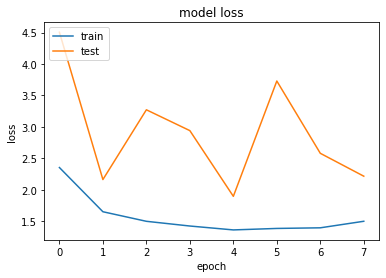

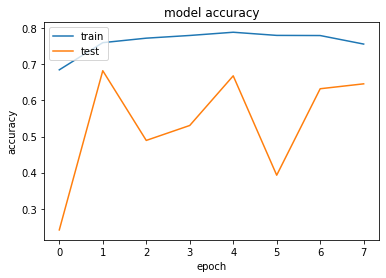

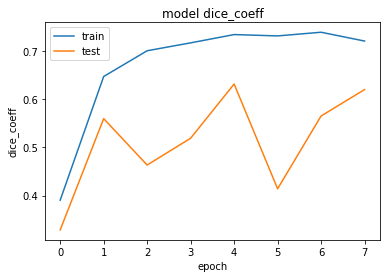

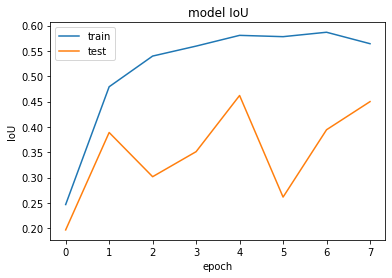

In [73]:
history = vgg_unet_history_tl
plot_history(history, list(history.history.keys()))

##### Evaluation

In [74]:
vgg_unet_evaluate_tl = vgg_unet_model_tl.evaluate(x_val,y_val)

11/11 [==============================] - 1s 37ms/step - loss: 2.2153 - accuracy: 0.6459 - dice_coeff: 0.6201 - IoU: 0.4495


In [75]:
print("UNET model loss:", round(vgg_unet_evaluate_tl[0],3))
print("UNET model accuracy:", round(vgg_unet_evaluate_tl[1],3))
print("UNET model dice coeff:", round(vgg_unet_evaluate_tl[2],3))
print("UNET model indice de Jacuard:", round(vgg_unet_evaluate_tl[3],3))
print("UNET model train time:", round(t_vgg_unet_tl/60,3), 'minutes')

UNET model loss: 2.215
UNET model accuracy: 0.646
UNET model dice coeff: 0.62
UNET model indice de Jacuard: 0.449
UNET model train time: 2.16 minutes


#### Entraînemet du modèle avec augmentation des images

In [76]:
aug_vgg_unet_model_tl = build_vgg_unet_model()

aug_vgg_unet_model_tl.compile(optimizer = tf.keras.optimizers.Adam(),
                    loss = total_loss,
                    metrics = ["accuracy", dice_coeff, IoU])

In [77]:
aug_vgg_unet_model_tl.summary()

Model: "VGG16_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 128, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 256, 64  1792        ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                       

In [78]:
batch_size = 10
len_aug = 60
training_generator = MyGenerator(train_path['image'].values,
                                 train_path['mask'].values,
                                 len_aug = len_aug,
                                 batch_size = batch_size)

val_generator = MyGenerator(val_path['image'].values,  
                            val_path['mask'].values, 
                            transformer = None,
                            batch_size = batch_size)

In [79]:
callbacks_es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                         patience = 3)

callbacks_chechpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath + '/AUG_VGG_UNET_TL',
    save_weights_only = False,
    mode='min',
    save_best_only = True)

callbacks = [callbacks_es, callbacks_chechpoint]

t0 = time()
aug_vgg_unet_history_tl = aug_vgg_unet_model_tl.fit(
    training_generator,
    validation_data = val_generator,
    epochs = epochs,
    workers = 16,
    callbacks = [callbacks]
    )

t_aug_vgg_unet_tl = time() - t0

Epoch 1/30
298/298 [==============================] - ETA: 0s - loss: 2.4868 - accuracy: 0.6553 - dice_coeff: 0.3062 - IoU: 0.1821

298/298 [==============================] - 334s 1s/step - loss: 2.4868 - accuracy: 0.6553 - dice_coeff: 0.3062 - IoU: 0.1821 - val_loss: 3.0875 - val_accuracy: 0.4961 - val_dice_coeff: 0.4223 - val_IoU: 0.2677
Epoch 2/30
298/298 [==============================] - 312s 1s/step - loss: 1.6938 - accuracy: 0.7428 - dice_coeff: 0.5709 - IoU: 0.4018 - val_loss: 3.1099 - val_accuracy: 0.5029 - val_dice_coeff: 0.4703 - val_IoU: 0.3077
Epoch 3/30
298/298 [==============================] - ETA: 0s - loss: 1.4328 - accuracy: 0.7656 - dice_coeff: 0.6614 - IoU: 0.4945

298/298 [==============================] - 330s 1s/step - loss: 1.4328 - accuracy: 0.7656 - dice_coeff: 0.6614 - IoU: 0.4945 - val_loss: 2.2908 - val_accuracy: 0.5325 - val_dice_coeff: 0.5260 - val_IoU: 0.3569
Epoch 4/30
298/298 [==============================] - 311s 1s/step - loss: 1.3437 - accuracy: 0.7814 - dice_coeff: 0.6980 - IoU: 0.5364 - val_loss: 2.8690 - val_accuracy: 0.4349 - val_dice_coeff: 0.5152 - val_IoU: 0.3471
Epoch 5/30
298/298 [==============================] - ETA: 0s - loss: 1.2308 - accuracy: 0.7993 - dice_coeff: 0.7286 - IoU: 0.5734

298/298 [==============================] - 329s 1s/step - loss: 1.2308 - accuracy: 0.7993 - dice_coeff: 0.7286 - IoU: 0.5734 - val_loss: 1.6459 - val_accuracy: 0.7432 - val_dice_coeff: 0.7036 - val_IoU: 0.5434
Epoch 6/30
298/298 [==============================] - 311s 1s/step - loss: 1.1981 - accuracy: 0.8034 - dice_coeff: 0.7413 - IoU: 0.5893 - val_loss: 1.8346 - val_accuracy: 0.7222 - val_dice_coeff: 0.6623 - val_IoU: 0.4957
Epoch 7/30
298/298 [==============================] - ETA: 0s - loss: 1.2073 - accuracy: 0.7980 - dice_coeff: 0.7471 - IoU: 0.5969

298/298 [==============================] - 328s 1s/step - loss: 1.2073 - accuracy: 0.7980 - dice_coeff: 0.7471 - IoU: 0.5969 - val_loss: 1.3236 - val_accuracy: 0.7745 - val_dice_coeff: 0.7497 - val_IoU: 0.6000
Epoch 8/30
298/298 [==============================] - 311s 1s/step - loss: 1.1534 - accuracy: 0.8055 - dice_coeff: 0.7622 - IoU: 0.6164 - val_loss: 1.4156 - val_accuracy: 0.7741 - val_dice_coeff: 0.7372 - val_IoU: 0.5842
Epoch 9/30
298/298 [==============================] - 317s 1s/step - loss: 1.1070 - accuracy: 0.8135 - dice_coeff: 0.7738 - IoU: 0.6314 - val_loss: 1.4015 - val_accuracy: 0.7504 - val_dice_coeff: 0.7357 - val_IoU: 0.5825
Epoch 10/30
298/298 [==============================] - ETA: 0s - loss: 1.0945 - accuracy: 0.8127 - dice_coeff: 0.7758 - IoU: 0.6340

298/298 [==============================] - 329s 1s/step - loss: 1.0945 - accuracy: 0.8127 - dice_coeff: 0.7758 - IoU: 0.6340 - val_loss: 1.2231 - val_accuracy: 0.7946 - val_dice_coeff: 0.7660 - val_IoU: 0.6215
Epoch 11/30
298/298 [==============================] - 311s 1s/step - loss: 1.1146 - accuracy: 0.8089 - dice_coeff: 0.7681 - IoU: 0.6243 - val_loss: 2.0338 - val_accuracy: 0.6388 - val_dice_coeff: 0.6045 - val_IoU: 0.4337
Epoch 12/30
298/298 [==============================] - ETA: 0s - loss: 1.0777 - accuracy: 0.8159 - dice_coeff: 0.7755 - IoU: 0.6336

298/298 [==============================] - 329s 1s/step - loss: 1.0777 - accuracy: 0.8159 - dice_coeff: 0.7755 - IoU: 0.6336 - val_loss: 1.0306 - val_accuracy: 0.8271 - val_dice_coeff: 0.7901 - val_IoU: 0.6536
Epoch 13/30
298/298 [==============================] - ETA: 0s - loss: 0.9922 - accuracy: 0.8317 - dice_coeff: 0.7981 - IoU: 0.6642

298/298 [==============================] - 323s 1s/step - loss: 0.9922 - accuracy: 0.8317 - dice_coeff: 0.7981 - IoU: 0.6642 - val_loss: 0.9705 - val_accuracy: 0.8377 - val_dice_coeff: 0.8027 - val_IoU: 0.6710
Epoch 14/30
298/298 [==============================] - 311s 1s/step - loss: 1.1013 - accuracy: 0.8099 - dice_coeff: 0.7711 - IoU: 0.6281 - val_loss: 1.2915 - val_accuracy: 0.7906 - val_dice_coeff: 0.7562 - val_IoU: 0.6088
Epoch 15/30
298/298 [==============================] - 318s 1s/step - loss: 1.0209 - accuracy: 0.8254 - dice_coeff: 0.7909 - IoU: 0.6544 - val_loss: 1.1450 - val_accuracy: 0.7971 - val_dice_coeff: 0.7658 - val_IoU: 0.6211
Epoch 16/30
298/298 [==============================] - 318s 1s/step - loss: 1.0583 - accuracy: 0.8187 - dice_coeff: 0.7844 - IoU: 0.6456 - val_loss: 1.4165 - val_accuracy: 0.7492 - val_dice_coeff: 0.7235 - val_IoU: 0.5674


##### Learning Curve

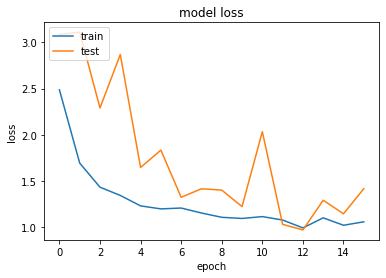

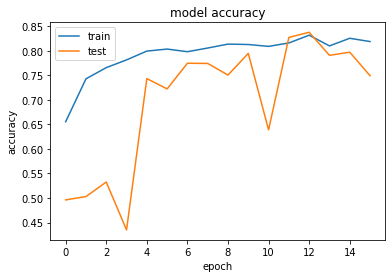

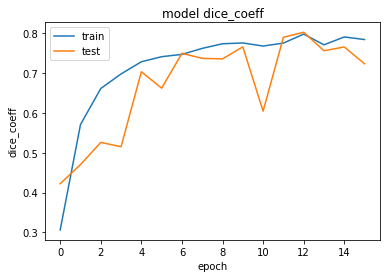

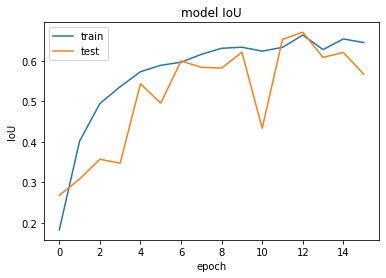

In [80]:
history = aug_vgg_unet_history_tl
plot_history(history, list(history.history.keys()))

##### Evaluation

In [87]:
aug_vgg_unet_evaluate_tl = aug_vgg_unet_model_tl.evaluate(x_val, y_val)

11/11 [==============================] - 0s 38ms/step - loss: 1.4164 - accuracy: 0.7492 - dice_coeff: 0.7236 - IoU: 0.5671


In [88]:
print("UNET model loss:", round(aug_vgg_unet_evaluate_tl[0],3))
print("UNET model accuracy:", round(aug_vgg_unet_evaluate_tl[1],3))
print("UNET model dice coeff:", round(aug_vgg_unet_evaluate_tl[2],3))
print("UNET model indice de Jacuard:", round(aug_vgg_unet_evaluate_tl[3],3))
print("UNET model train time:", round(t_aug_vgg_unet_tl/60,3), 'minutes')

UNET model loss: 1.416
UNET model accuracy: 0.749
UNET model dice coeff: 0.724
UNET model indice de Jacuard: 0.567
UNET model train time: 85.48 minutes


## Sauvegarde

In [102]:
import pickle 

times = {'VGG_UNET_CE' : t_vgg_unet_ce/60,
         'VGG_UNET_WCE' : t_vgg_unet_wce/60,
         'VGG_UNET_DL' : t_vgg_unet_dl/60,
         'VGG_UNET_TL' : t_vgg_unet_tl/60,
         'AUG_VGG_UNET_CE' : t_aug_vgg_unet_ce/60,
         'AUG_VGG_UNET_WCE' : t_aug_vgg_unet_wce/60,
         'AUG_VGG_UNET_DL' : t_aug_vgg_unet_dl/60,
         'AUG_VGG_UNET_TL' : t_aug_vgg_unet_tl/60,
         }

# Sauvegarde
with open(checkpoint_filepath + "vgg_times.pkl", "wb") as tf:
    pickle.dump(times,tf)

In [98]:
times

{'VGG_UNET_CE': 2.4453004360198975,
 'VGG_UNET_WCE': 3.107191606362661,
 'VGG_UNET_DL': 5.877069397767385,
 'VGG_UNET_TL': 2.15953137477239,
 'AUG_VGG_UNET_CE': 22.05803496837616,
 'AUG_VGG_UNET_WCE': 32.31434298753739,
 'AUG_VGG_UNET_DL': 46.07354467312495,
 'AUG_VGG_UNET_TL': 85.48029823303223}

In [99]:
print("Done!")

Done!
